# VIP Reparameterisation
This notebook contains results of VIP reparameterisation by using a collection of models to be provided as references in our future experiments. <br>
Each of results shows how $\lambda \in [0, 1]$ are trained with different models, where $\lambda$ means how much we reparameterise the corresponding sample site in the location-scale family. <br>
$\lambda = 0$ means the sample site is fully reparameterised, and $\lambda = 1$ means it is not reparameterised at all.

In [2]:
%matplotlib inline
import os
import pyro
import torch
import random
import numpy as np
import torch.optim as to
import pyro.optim  as po
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pyro.infer import Trace_ELBO, SVI
from pyro.poutine import reparam
from pyro.infer.autoguide import AutoNormal

os.chdir("../")
from VIPReparam import VIPReparam
from AutoReparam import GNN, AutoReparam, MLP
from model import neals_funnel, eight_schools
from util import plot_scatter3d

torch.set_default_device("cuda:0")

### Neal's Funnel with VIP
Here we use variants of the Neal's Funnel example which contain randomly generated observed variables $y \in (-20, 20)$ and noises $\sigma \in (0, 20)$. <br>
The plots show $\lambda \in [0, 1]$ trained with models using different $y$ and $\sigma$. (`None` argument passed to `VIPReparam` enables to learn the $\lambda$.) <br>
[Sangho: In certain area (e.g., around $(y, \sigma) = (-20, 1)$ and $(y, \sigma) = (20, 1)$), it converges slow. The reason I guess is because the (target) posterior distribution is far from the initial guide distribution.]

  0%|          | 0/500 [00:00<?, ?it/s]

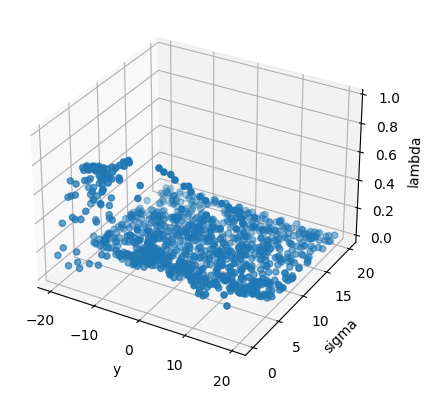

  0%|          | 0/500 [00:00<?, ?it/s]

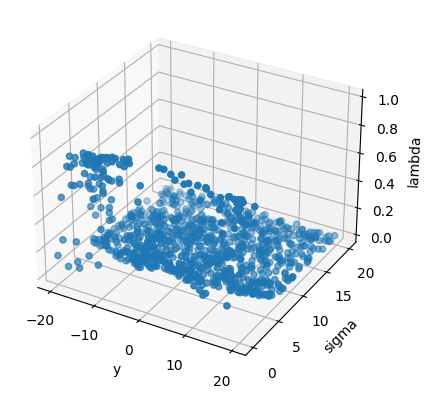

  0%|          | 0/500 [00:00<?, ?it/s]

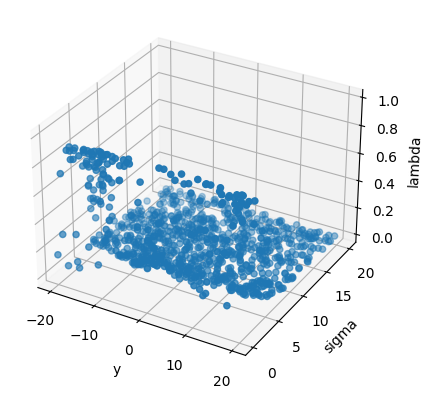

  0%|          | 0/500 [00:00<?, ?it/s]

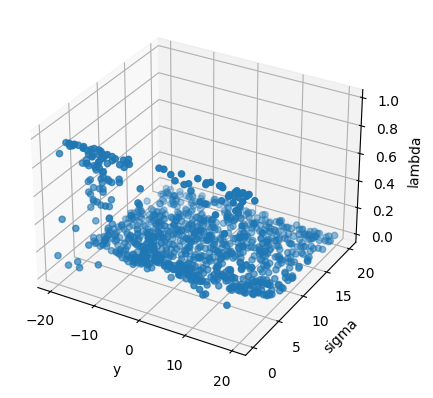

  0%|          | 0/500 [00:00<?, ?it/s]

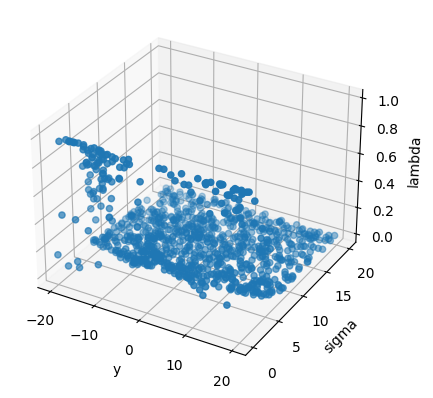

In [3]:
pyro.clear_param_store()

n_model = 1000
y = torch.rand(n_model) * 40 - 20
sigma = torch.rand(n_model) * 20
optim_svi = po.ClippedAdam({"lr": 1e-1})
loss = Trace_ELBO(num_particles=100, vectorize_particles=True)

model = neals_funnel
reparam_model = reparam(model, config={"x": VIPReparam(None, batch_depth=1)})
guide = AutoNormal(reparam_model)

for _ in range(5):
    for _ in (epoch := tqdm(range(500))):
        svi = SVI(reparam_model, guide, optim_svi, loss)
        _loss = svi.step(y, sigma)
        epoch.set_description("Loss: {:.4}".format(_loss))
    params = pyro.get_param_store()
    plot_scatter3d(y, sigma, params["x_centered"], xlabel="y", ylabel="sigma", zlabel="lambda")

### Eight Schools with VIP
Here we use `Eight Schools` examples whose observed values and noises of the first school are randomly generated as $y \in (-20, 20)$ and $\sigma \in (0, 20)$, and those of the other schools are fixed as $0$ and $1$. <br>
[Sangho: Again, in certain area (e.g., around $(y, \sigma) = (-20, 1)$ and $(y, \sigma) = (20, 1)$), it converges slow.]

  0%|          | 0/500 [00:00<?, ?it/s]

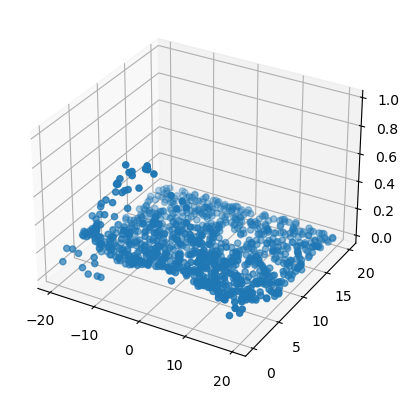

  0%|          | 0/500 [00:00<?, ?it/s]

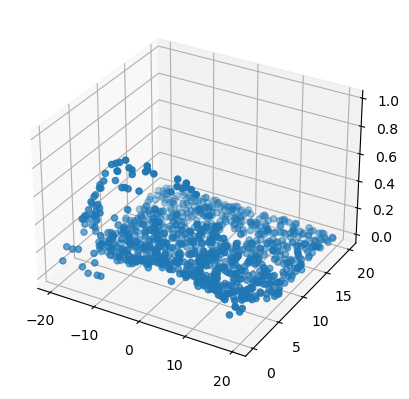

  0%|          | 0/500 [00:00<?, ?it/s]

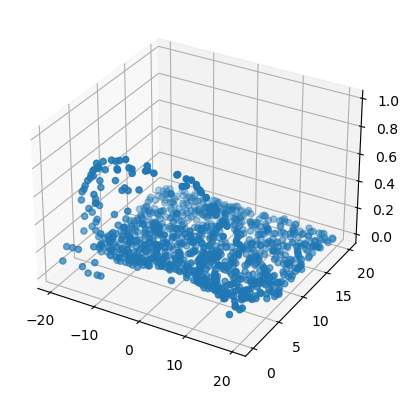

  0%|          | 0/500 [00:00<?, ?it/s]

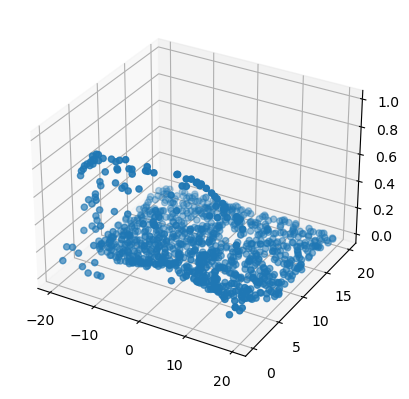

  0%|          | 0/500 [00:00<?, ?it/s]

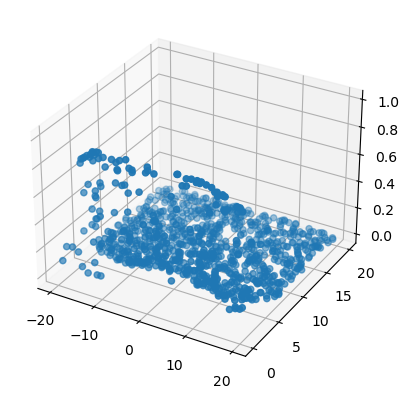

In [4]:
pyro.clear_param_store()

n_model_svi = 1000
y = torch.cat([torch.rand(1, n_model_svi) * 40 - 20, torch.zeros(7, n_model_svi)])
sigma = torch.cat([torch.rand(1, n_model_svi) * 20, torch.ones(7, n_model_svi)])
optim_svi = po.ClippedAdam({"lr": 1e-1})
loss = Trace_ELBO(num_particles=100, vectorize_particles=True)

model = eight_schools
reparam_model = reparam(model, config={"theta": VIPReparam(None, batch_depth=2)})
guide = AutoNormal(reparam_model)

for _ in range(5):
    for _ in (epoch := tqdm(range(500))):
        svi = SVI(reparam_model, guide, optim_svi, loss)
        _loss = svi.step(y, sigma)
        epoch.set_description("Loss: {:.4}".format(_loss))
    params = pyro.get_param_store()
    plot_scatter3d(y[0], sigma[0], params["theta_centered"][0])